# Bayes Factor

The Bayes factor compares the evidence across **one family of models to that of another family**, averaged over the **parameter uncertainty** within each family; while likelihood ratios compare one specific model to another specific model.

# Graphical Summary

![Fig](./graphical_summary/slides/Slide24.png)

# Key Formula

Given a model selection problem in which one wishes to choose between two models on the basis of observed data $\text{D}$, the plausibility of the two different models $\text{M}_1$ and $\text{M}_2$, parametrised by model parameter vectors $\theta_1$ and $\theta_2$, is assessed by the Bayes factor $\text{BF}$ given by:

$$
\text{BF}_{21} = \frac{L(\text{M}_2|\text{D})}{L(\text{M}_1|\text{D})} ={\frac {\int \Pr(\theta_{2}|M_{2})\Pr(D|\theta_{2},M_{2})\,d\theta _{2}}{\int \Pr(\theta_{1}|M_{1})\Pr(D|\theta_{1},M_{1})\,d\theta _{1}}}
$$

# Technical Details

- If instead of integrating over all parameter values, we use only the likelihood at the maximum likelihood estimate (MLE) versus the null, the comparison becomes a classical likelihood-ratio test. **The MLE represents just a single point from what Bayes factors consider as entire families of models.**
- This difference reflects the fundamental distinction between frequentist and Bayesian approaches: **frequentists treat parameters as fixed but unknown values to be estimated, while Bayesians treat unknown parameters as having distributions that reflect our uncertainty about them**.
- An advantage of Bayes factors is that they automatically include a penalty for model complexity by **averaging over parameter uncertainty**, thus guarding against overfitting. For models where explicit likelihood evaluation is computationally costly, approximate Bayesian computation can be used, though with potential bias in the Bayes factor estimates.

# Related Topics

- [ordinary least squares](https://statfungen.github.io/statgen-primer/ordinary_least_squares.html)
- [summary statistics](https://statfungen.github.io/statgen-primer/summary_statistics.html)
- [likelihood](https://statfungen.github.io/statgen-primer/likelihood.html)
- [likelihood ratio](https://statfungen.github.io/statgen-primer/likelihood_ratio.html)
- [Bayesian and frequentist](https://statfungen.github.io/statgen-primer/Bayesian_frequentist.html)
- [random effect](https://statfungen.github.io/statgen-primer/random_effect.html)

# Example

We will use the same genetic example from the [Lecture: likelihood](https://statfungen.github.io/statgen-primer/likelihood.html), and recall the concepts of MLE as we did in Example 2 in [Lecture: maximum likelihood estimation](https://statfungen.github.io/statgen-primer/maximum_likelihood_estimation.html). 

Now you're faced with a decision problem: Should you believe there's no genetic effect at all, or should you believe there's some kind of effect? But here's where it gets interesting - if you think there's an effect, how do you handle the uncertainty about exactly how big that effect might be?

This leads to two different approaches for comparing hypotheses:
- **Likelihood ratios**: Compare specific effect sizes (like "no effect" vs "exactly 0.5 units per allele", as we did in [Lecture: likelihood ratio](https://statfungen.github.io/statgen-primer/likelihood_ratio.html)) 
- **Bayes factors**: Compare families of models

For Bayes factors, we'll compare these two model families:
- **Model Family 1**: No effect ($\beta = 0$, point mass)
- **Model Family 2**: Some effect ($\beta \sim N(0, 1)$, representing our uncertainty about the effect size). Here $\beta$ is a random effect.

Let's see how these approaches work with the same data.

In [1]:
# Clear the environment
rm(list = ls())
set.seed(19)  # For reproducibility

# Generate genotype data for 5 individuals at 1 variant
N <- 5
genotypes <- c("CC", "CT", "TT", "CT", "CC")  # Individual genotypes
names(genotypes) <- paste("Individual", 1:N)

# Define alternative allele
alt_allele <- "T"

# Convert to additive genotype coding (count of alternative alleles)
Xraw_additive <- numeric(N)
for (i in 1:N) {
  alleles <- strsplit(genotypes[i], "")[[1]]
  Xraw_additive[i] <- sum(alleles == alt_allele)
}
names(Xraw_additive) <- names(genotypes)

# Standardize genotypes
X <- scale(Xraw_additive, center = TRUE, scale = TRUE)[,1]

# Set true beta and generate phenotype data
true_beta <- 0.4
true_sd <- 1.0

# Generate phenotype with true effect
Y <- X * true_beta + rnorm(N, 0, true_sd)

We then define the likelihood function:

In [2]:
# Likelihood function for normal distribution
likelihood <- function(beta, sd, X, Y) {
  mu <- X * beta
  prod(dnorm(Y, mean = mu, sd = sd, log = FALSE))
}

# Log-likelihood function (more numerically stable)
log_likelihood <- function(beta, sd, X, Y) {
  mu <- X * beta
  sum(dnorm(Y, mean = mu, sd = sd, log = TRUE))
}

## Likelihood Ratio Analysis

We have done this in [Lecture: likelihood ratio](https://statfungen.github.io/statgen-primer/likelihood_ratio.html), just to recap here with the comparison between Model 1 and Model 2:

In [3]:
# Test three different models with different beta values
beta_values <- c(0, 0.5)  # Three different effect sizes to test
model_names <- paste0("Model ", 1:2, " (beta = ", beta_values, ")")

# Calculate likelihoods and log-likelihoods
results <- data.frame(
  Model = model_names,
  Beta = beta_values,
  Likelihood = numeric(2),
  Log_Likelihood = numeric(2)
)

for (i in 1:2) {
  results$Likelihood[i] <- likelihood(beta = beta_values[i], sd = true_sd, X = X, Y = Y)
  results$Log_Likelihood[i] <- log_likelihood(beta = beta_values[i], sd = true_sd, X = X, Y = Y)
}

# Calculate all pairwise likelihood ratios
model_pairs <- combn(1:2, 2)  # All combinations of 2 models from 3
n_pairs <- ncol(model_pairs)

lr_results <- data.frame(
  Comparison = character(n_pairs),
  Model_1 = character(n_pairs),
  Model_2 = character(n_pairs),
  LR = numeric(n_pairs),
  Log_LR = numeric(n_pairs),
  Interpretation = character(n_pairs),
  stringsAsFactors = FALSE
)

for (i in 1:n_pairs) {
  m1 <- model_pairs[1, i]  # First model index
  m2 <- model_pairs[2, i]  # Second model index
  
  # Calculate likelihood ratio: L(M1|D) / L(M2|D)
  lr_value <- results$Likelihood[m1] / results$Likelihood[m2]
  log_lr_value <- results$Log_Likelihood[m1] - results$Log_Likelihood[m2]
  
  # Determine interpretation
  if (lr_value > 1) {
    interpretation <- paste("Model", m1, "better supported")
  } else if (lr_value < 1) {
    interpretation <- paste("Model", m2, "better supported")
  } else {
    interpretation <- "Equal support"
  }
  
  # Store results
  lr_results$Comparison[i] <- paste("Model", m1, "vs Model", m2)
  lr_results$Model_1[i] <- results$Model[m1]
  lr_results$Model_2[i] <- results$Model[m2]
  lr_results$LR[i] <- lr_value
  lr_results$Log_LR[i] <- log_lr_value
  lr_results$Interpretation[i] <- interpretation
}
lr_results

Comparison,Model_1,Model_2,LR,Log_LR,Interpretation
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
Model 1 vs Model 2,Model 1 (beta = 0),Model 2 (beta = 0.5),0.8747253,-0.1338454,Model 2 better supported


## Bayes Factor Analysis (Model Families)

We are trying to compare two model families:
  - **Model Family 1: "No Effect"**
    - This is actually just a **single model**: beta = 0 exactly
    - It's a "point mass" prior - all probability is concentrated at beta = 0
    - There's no uncertainty about the parameter value within this family
    - We're saying: "The genetic variant has absolutely no effect on height"

  - **Model Family 2: "Some Effect"**
    - This is a **family of infinitely many models**: beta can be any value from the normal distribution $N(0, 1)$
    - Different values of beta within this family have different probabilities based on the prior
    - We're saying: "We believe there's some effect, but we're uncertain about exactly how big it is"
    - Values around 0 are most plausible, but values like 0.5, 1.0, 0.9, etc. are also possible with lower probability


Now let's compare model families by integrating over parameter uncertainty:

In [4]:
# Define prior distributions for each model family
# Model Family 1: beta = 0, point mass
# Model Family 2: beta ~ Normal(0, 1)

# For Bayes Factor calculation, we need to integrate over the prior
# For the second family of models, we'll use numerical integration

# Define the prior for the second model family
prior_mean <- 0
prior_sd <- 1

# Function to calculate marginal likelihood for the second model family
# This integrates: P(Data|beta) * P(beta) over all beta values
marginal_likelihood_second_family <- function(X, Y, sd, prior_mean, prior_sd, 
                                       beta_range = c(-1, 2), n_points = 1000) {
  # Create grid of beta values
  beta_grid <- seq(beta_range[1], beta_range[2], length.out = n_points)
  
  # Calculate likelihood * prior for each beta value
  integrand <- numeric(n_points)
  for (i in 1:n_points) {
    beta_i <- beta_grid[i]
    lik_i <- likelihood(beta_i, sd, X, Y)
    prior_i <- dnorm(beta_i, mean = prior_mean, sd = prior_sd)
    integrand[i] <- lik_i * prior_i
  }
  
  # Numerical integration using trapezoidal rule
  delta_beta <- diff(beta_grid)[1]
  marginal_lik <- sum(integrand) * delta_beta
  
  return(marginal_lik)
}

# Calculate marginal likelihoods
marginal_lik_model_family_1 <- results$Likelihood[1]  # Point mass at beta = 0
marginal_lik_model_family_2 <- marginal_likelihood_second_family(X, Y, true_sd, prior_mean, prior_sd)

# Calculate Bayes Factor
bf <- marginal_lik_model_family_2 / marginal_lik_model_family_1
bf

[1] 0.5238395

## Visualization

Let's visualize how the different approaches work:


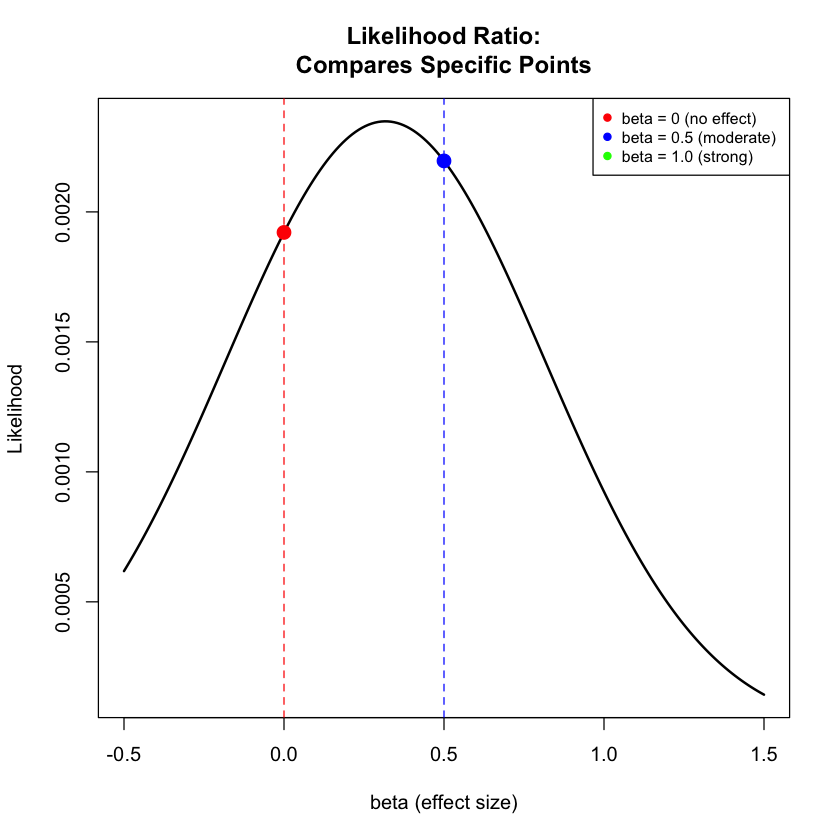

In [5]:
# Create a range of beta values for plotting
beta_range <- seq(-0.5, 1.5, length.out = 200)
likelihood_curve <- numeric(length(beta_range))

# Calculate likelihood for each beta value
for (i in 1:length(beta_range)) {
  likelihood_curve[i] <- likelihood(beta_range[i], true_sd, X, Y)
}

# Figure 1: Likelihood Ratio comparison (specific points)
plot(beta_range, likelihood_curve, type = "l", lwd = 2, col = "black",
     xlab = "beta (effect size)", ylab = "Likelihood", 
     main = "Likelihood Ratio:\nCompares Specific Points")

# Mark the specific models being compared
points(beta_values[1], results$Likelihood[1], col = "red", pch = 19, cex = 1.5)    # beta = 0
points(beta_values[2], results$Likelihood[2], col = "blue", pch = 19, cex = 1.5)   # beta = 0.5
points(beta_values[3], results$Likelihood[3], col = "green", pch = 19, cex = 1.5)  # beta = 1.0

# Add vertical lines (without alpha parameter)
abline(v = beta_values[1], col = "red", lty = 2)
abline(v = beta_values[2], col = "blue", lty = 2)
abline(v = beta_values[3], col = "green", lty = 2)

legend("topright", 
       c("beta = 0 (no effect)", "beta = 0.5 (moderate)", "beta = 1.0 (strong)"),
       col = c("red", "blue", "green"), pch = 19, cex = 0.8)


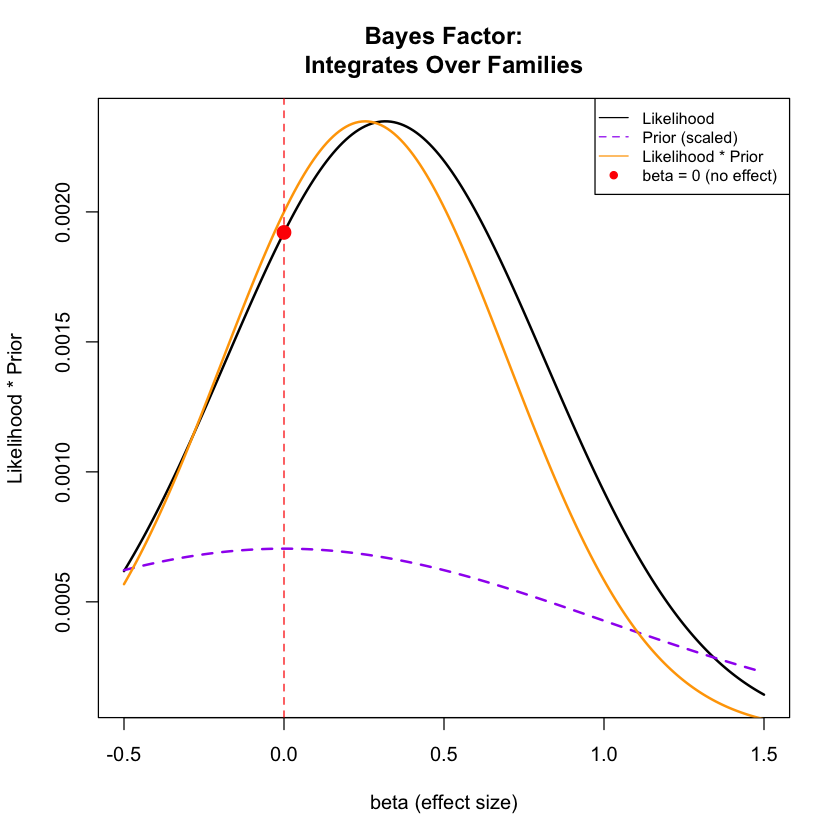

In [6]:
plot(beta_range, likelihood_curve, type = "l", lwd = 2, col = "black",
     xlab = "beta (effect size)", ylab = "Likelihood * Prior", 
     main = "Bayes Factor:\nIntegrates Over Families")

# Show the prior distribution for "some effect" model
prior_curve <- dnorm(beta_range, mean = prior_mean, sd = prior_sd)
# Scale prior for visualization
prior_curve_scaled <- prior_curve * max(likelihood_curve) / max(prior_curve) * 0.3

lines(beta_range, prior_curve_scaled, col = "purple", lwd = 2, lty = 2)

# Show the posterior (likelihood * prior)
posterior_curve <- likelihood_curve * prior_curve
posterior_curve_scaled <- posterior_curve / max(posterior_curve) * max(likelihood_curve)
lines(beta_range, posterior_curve_scaled, col = "orange", lwd = 2)

# Mark no effect model
points(beta_values[1], results$Likelihood[1], col = "red", pch = 19, cex = 1.5)
abline(v = beta_values[1], col = "red", lty = 2)

legend("topright", 
       c("Likelihood", "Prior (scaled)", "Likelihood * Prior", "beta = 0 (no effect)"),
       col = c("black", "purple", "orange", "red"), 
       lty = c(1, 2, 1, NA), pch = c(NA, NA, NA, 19), cex = 0.8)

**Exercise**: Here the Bayes factor between the two models is ~0.52, which doesn't suggest very strong evidence. This is mainly because of the fact that there are only five samples in the data. Try to increase the number of samples and see how Bayes factor changes.